MainProcess


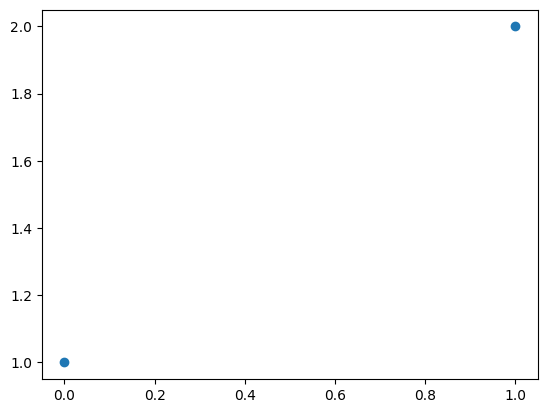

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
import flg_model
fls.profiling=False
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
# import shutil
# res_dir = fls.result_dir + '/many_full_res/'
# temp_dir = fls.temp_dir + '/temptemp/'
# fls.remove_and_make_dir(res_dir)
# fls.remove_and_make_dir(temp_dir)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models-3/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)

In [ ]:
files = glob.glob(fls.result_dir + 'many_full_res/*.pickle')
all_scores = []
for f in files:
    loaded_data = fls.dill_load(f)
    test_data = loaded_data.test_data[25:35]
    #print(loaded_data.modifier_values)
    base_model = copy.deepcopy(loaded_data.trained_model)
    print(f, loaded_data.trained_model.step1Labels.concentration, loaded_data.trained_model.step1Labels.n_ensemble)
    highest_false_score = []
    real_score = []
    data_list = []
    for i_type in range(3):
        base_model = copy.deepcopy(loaded_data.trained_model)
        base_model.data_after_step2 = copy.deepcopy(loaded_data.inferred_test_data)
        base_model.run_in_parallel=False
        model = base_model
        #model.step1Labels.n_epochs = 2
        #m.step2Motors.distance_threshold = 10.
        # if i_type == 0:
        #     # baseline
        #     pass     
        # elif i_type==1:
        #     # other seed
        #     model.step1Labels.trained_model = loaded_data.trained_model.step1Labels.trained_model[1:2]
        # elif i_type==2:
        #     model.step1Labels.preprocessor.voxel_scale = 0.9
        # elif i_type==3:
        #     model.step1Labels.preprocessor.voxel_scale = 0.8
        # elif i_type==4:
        #     model.step1Labels.preprocessor.blur_xy *= 0.8
        # elif i_type==5:
        #     model.step1Labels.preprocessor.blur_xy *= 1.2   
        # elif i_type==6:
        #     model.step1Labels.preprocessor.clip_value = 2.5
        # elif i_type==7:
        #     model.step1Labels.preprocessor.clip_value = 3.5
        # elif i_type==8:
        #     model.step1Labels.preprocessor.apply_transpose = True
        # elif i_type==9:
        #     model.step1Labels.preprocessor.apply_flipud = True
        if i_type == 0:
            # conc1
            pass
        elif i_type == 1:
            model.step2Motors = flg_model.FindClustersMultiZ()
            model.step2Motors.z_range = 2*i_type
            #model.step2Motors.gamma= 0.5+0.1*(i_type-1)   
        elif i_type == 2:
            model.data_after_step2 = []
            model.step2Motors = flg_model.FindClustersMultiZ()
            model.step2Motors.z_range = 2*i_type
            model.step1Labels.confidence_threshold = 0.01
            model.step1Labels.relative_confidence_threshold = 0.0
            #model.step2Motors.gamma= 0.5+0.1*(i_type-1)   
        import io
        import contextlib

        with contextlib.redirect_stdout(io.StringIO()) as f:
            inferred_data = model.infer(test_data)
        #for d in inferred_data:
        #    d.labels_unfiltered = d.labels_unfiltered2 
        fls.mark_tf_pn(inferred_data, test_data)          
        data_list.append(inferred_data)
        this_highest_false_score = []
        this_real_score = []
        for i,r in zip(inferred_data, test_data):
            false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
            if len(false_positives)>0:
                this_highest_false_score.append(np.max(false_positives['confidence']))
            else:
                this_highest_false_score.append(0)
            if len(r.labels)>0:
                true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
                #print(true_positives)
                if len(true_positives)>0:
                    this_real_score.append(np.max(true_positives['confidence']))
                else:
                    this_real_score.append(0)
        highest_false_score.append(this_highest_false_score)
        real_score.append(this_real_score)
    this_scores = []
    for d in data_list:
        n_corr=0
        n_total=0
        for i,r in zip(d,test_data):
            if len(r.labels)>0:# and 'tom' in r.name:
                n_total+=1
                ind = np.argmax(i.labels_unfiltered['confidence'])
                if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                    n_corr += 1
        #a,b = flg_diagnostics.expand_and_reinfer(d,test_data,model.step3Output.select_motors,0.7)
        score = fls.score_competition_metric(a,b)
        print(n_corr/n_total, score)
        this_scores.append(score[2])
    all_scores.append(this_scores)
            #print(i.labels_unfiltered)
        # i_baseline = 0
        # for i_new in np.arange(1,len(highest_false_score)):
        #     _,ax=plt.subplots(1,2,figsize=(10,5))
        #     plt.sca(ax[0])
        #     plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
        #     plt.xlabel('Highest false score baseline')
        #     plt.ylabel('Highest false score new')
        #     plt.grid(True)
        #     plt.axline((0,0),slope=1)
        #     plt.sca(ax[1])
        #     plt.scatter(real_score[i_baseline], real_score[i_new])
        #     plt.xlabel('True score baseline')
        #     plt.ylabel('True score new')
        #     plt.grid(True)
        #     plt.axline((0,0),slope=1)
        #     plt.suptitle(str(i_new))
        

d:/flagellar/results/many_full_res\Baseline_0_5c5f4bbd_901 _f.pickle 1 4
------------------
Empty DataFrame
Columns: [index, z, y, x, confidence, i_model]
Index: []
Empty DataFrame
Columns: [index, z, y, x, confidence, i_model]
Index: []
   index    z    y    x  confidence  i_model
0      0  171  515  324    0.308105        2
1      1  170  515  324    0.141724        2
Empty DataFrame
Columns: [index, z, y, x, confidence, i_model]
Index: []
------------------
FINAL
     z    y    x  confidence
0  171  515  324    0.077026

------------------
    index    z    y    x  confidence  i_model
5       6  219  149  773    0.191895        0
6       7  220  149  773    0.175537        0
10     12  218  149  772    0.128906        0
12     14  217  149  772    0.104858        0
14     17  221  150  772    0.085388        0
    index    z    y    x  confidence  i_model
16     19  217  150  771    0.077209        1
18     22  219  150  772    0.068298        1
    index    z    y    x  confidence 

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Clearing cupy
YOLOv8m summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
YOLOv8m summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
YOLOv8m summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
YOLOv8m summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
Processing tomogram tomo_499ee0 (1/1)
Processing 300 out of 300 slices (CONCENTRATION=1)
Processing 300 out of 300 slices (CONCENTRATION=1)
Processing 300 out of 300 slices (CONCENTRATION=1)
Processing 300 out of 300 slices (CONCENTRATION=1)
FINAL
     z    y    x  confidence  \
0  171  515  324    0.014477   
1  277  709  547    0.002284   
2  177  957  843    0.007638   
3  281  754  592    0.001280   
4  267  710  533    0.000656   
5   63  461  485    0.000587   
6   35  715  609    0.000468   
7   68  604  368    0.000694   

                                          all_scores  
0  [0, 0, 0, 0, 0, 0, 0.0181884765625, 0, 0, 0, 0...  
1  

In [ ]:
plt.scatter(np.array(all_scores)[:,1], np.array(all_scores)[:,2])
plt.grid(True)
plt.axline((1,1),slope=1,color='black')

In [ ]:
ass = np.array(all_scores)
np.mean(ass[:,1] - ass[:,0]), np.mean(ass[:,2] - ass[:,0])

In [ ]:
import scipy.stats
scipy.stats.ttest_1samp(ass[:,2]-ass[:,1],0.)

In [ ]:
ass[:,2]

In [ ]:
ass[:,0]